In [2555]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [2556]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_100_5_1e-1_wgan_v3_small' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_100_5_1e-1_wgan_v3_small_reals.npy']

In [2557]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [2558]:
reals.shape

(87, 1, 32, 32)

In [2559]:
reals.mean(1).shape

(87, 32, 32)

# Error of ASPA $i$

In [2560]:
"""
3739 is bad with errors: -20.025595	-59.902499	831.523538	-28.148670	22.250920	0.759872	-8.532101 (831% is CO)
4788 is good with errors: 4.121214	0.958426	0.045486	0.866588	-5.077431	-0.756804	2.978271
4998 is 'decent' with errors: 5.578141	7.753601	-6.975316	5.797133	39.391482	-1.526314	-41.867831
"""
i = 0 

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.00000,1.000000,1.000000
mean,-1.290408,-3.854789,-5.690996,-7.409562,2.176518e+27,5.608136e+07,1460.62028,-0.052518,20.263552
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-1.290408,-3.854789,-5.690996,-7.409562,2.176518e+27,5.608136e+07,1460.62028,-0.052518,20.263552
25%,-1.290408,-3.854789,-5.690996,-7.409562,2.176518e+27,5.608136e+07,1460.62028,-0.052518,20.263552
50%,-1.290408,-3.854789,-5.690996,-7.409562,2.176518e+27,5.608136e+07,1460.62028,-0.052518,20.263552
75%,-1.290408,-3.854789,-5.690996,-7.409562,2.176518e+27,5.608136e+07,1460.62028,-0.052518,20.263552
max,-1.290408,-3.854789,-5.690996,-7.409562,2.176518e+27,5.608136e+07,1460.62028,-0.052518,20.263552


In [2561]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-1.290408,-3.854789,-5.690996,-7.409562,2.176518e+27,5.608136e+07,1460.62028,-0.052518,20.263552


In [2562]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [2563]:
reals.shape

(87, 1, 32, 32)

In [2564]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(87, 1, 32, 32)

In [2565]:
reals.shape

(87, 1, 32, 32)

## Spectrum plot

In [2566]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [2567]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

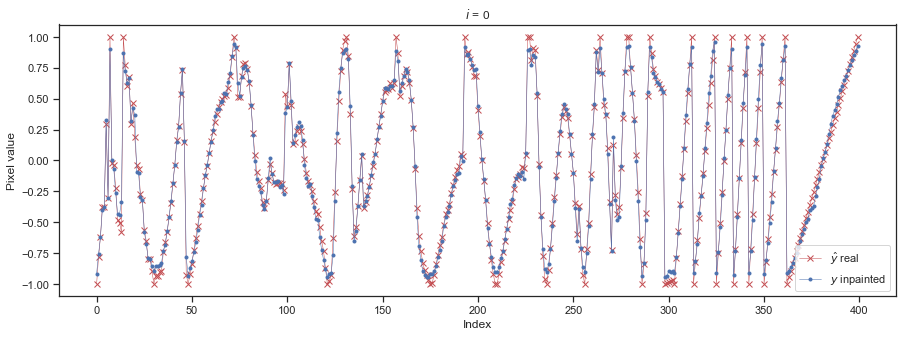

In [2568]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label=r'$\hat{y}$ real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label=r'$y$ inpainted')

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index')
plt.ylabel('Pixel value')
plt.legend()

# Pixel difference plot

Text(0, 0.5, '$y$-$\\hat{y}$')

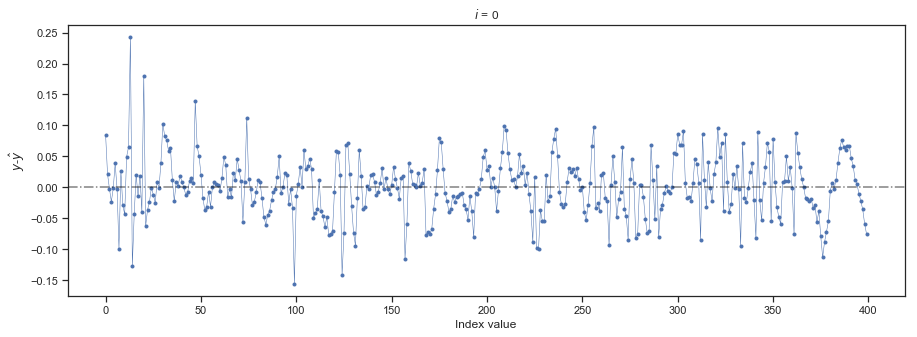

In [2569]:
plt.figure(figsize=(15,5))

plt.plot(inpainted_spec - real_spec, '.-', linewidth=0.5)

plt.axhline(y=0,  color='black', linestyle='-.', alpha=0.5)

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:370: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:371: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


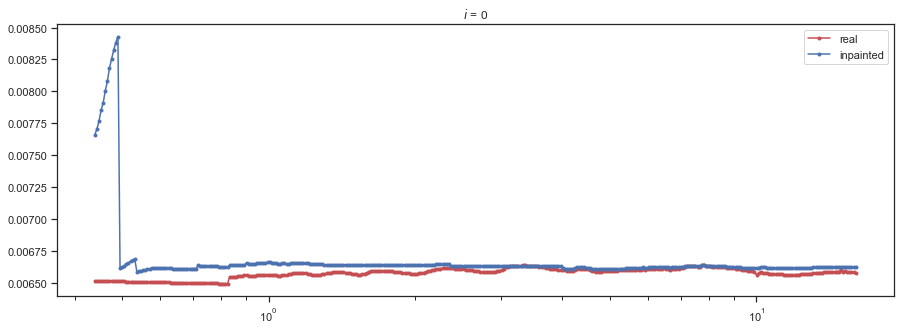

In [2570]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.figure(figsize=(15,5))
plt.plot(xhat, yhat, '.-', label='real', c='r')
plt.plot(x,y,'.-', label='inpainted')

plt.gca().set_xscale('log')

plt.title(r'$i$ = %s' % i)
plt.legend()

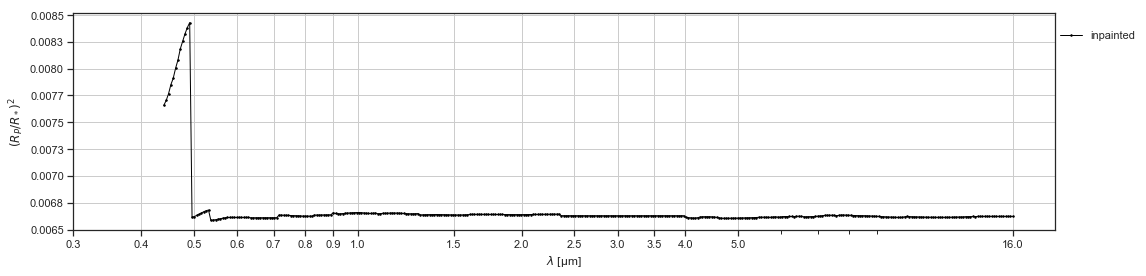

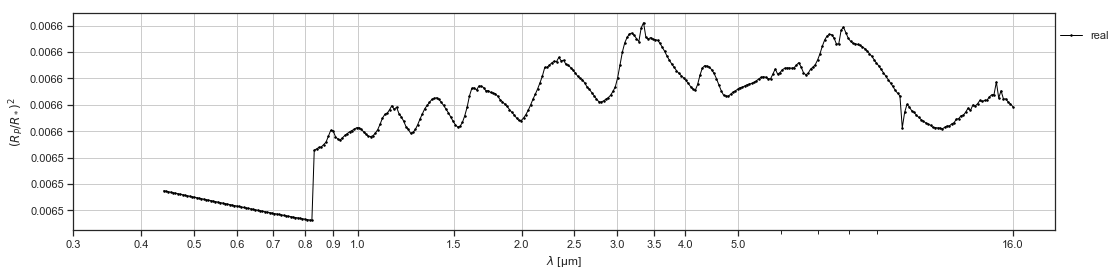

In [2571]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [2572]:
reals.shape

(87, 1, 32, 32)

In [2573]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [2574]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [2575]:
contextuals.shape

(87,)

In [2576]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [2577]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,1.305134,2.199226,41.955349,0.487812,1.849412,-0.319601,0.369215
std,17.138721,15.000458,101.379306,15.095806,34.594904,2.627310,29.835785
min,-29.630392,-22.217288,-62.683069,-32.292387,-49.849834,-4.855346,-44.138129
25%,-8.119039,-7.159231,-27.291109,-8.756686,-23.184138,-2.426910,-20.623226
50%,-3.082520,-0.433630,11.504260,-2.856265,-4.836217,-0.260886,-6.198479
75%,3.426054,5.960359,56.269443,5.034049,16.122917,1.280456,15.308328
max,60.796034,48.422503,386.015151,45.767090,105.885589,6.794517,97.100154


In [2578]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,29.040781,15.643669,122.691166,14.975963,-28.328567,0.272781,19.505297
1,-4.598158,-5.759823,3.553560,-1.108193,11.871948,-2.193746,61.498729
2,-4.624411,-0.433630,184.581662,-2.155581,-13.573812,-0.380289,-17.081652
3,0.026898,32.006615,44.276568,9.694382,-43.523573,-1.864768,-7.427771
4,36.045676,4.551136,39.329450,-5.701602,8.008677,1.389789,-44.138129
5,2.527680,-22.217288,-11.435099,34.095907,25.993792,-3.429331,35.937074
6,4.636885,-14.546821,-58.238816,-11.456612,-4.836217,-3.195759,15.507302
7,-4.142866,1.265453,-31.540752,5.706394,8.431275,-4.855346,20.688249
8,-10.918655,4.206676,150.357051,-3.124026,-18.601371,-1.766700,-33.405156
9,7.149486,13.440773,-34.266310,36.525995,-10.378964,-2.823587,-41.420254


In [2579]:
errors[(errors.co_mixratio_error < 0.1) & (errors.co_mixratio_error > -0.1)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error


In [2580]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [2581]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,87.000000,87.000000,87.000000,87.000000,8.700000e+01,8.700000e+01,87.000000,87.000000,87.000000,87.000000,...,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,-4.567050,-4.513410,-4.549170,-4.951469,2.664472e+27,8.205391e+07,1495.530013,-4.446507,-4.437926,-4.700816,...,1433.375780,1.305134,2.199226,41.955349,0.487812,1.849412,-0.319601,0.369215,-0.098785,24.733780
std,2.286288,2.265613,2.090705,2.318874,6.704841e+26,1.553176e+07,320.513427,2.144707,2.093614,0.875403,...,275.491228,17.138721,15.000458,101.379306,15.095806,34.594904,2.627310,29.835785,0.029736,4.893788
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-7.595835,-7.792504,-6.496528,...,1042.292297,-29.630392,-22.217288,-62.683069,-32.292387,-49.849834,-4.855346,-44.138129,-0.176072,18.449173
25%,-6.444445,-6.444445,-6.444445,-7.222222,2.277600e+27,6.680384e+07,1222.222209,-6.513491,-6.230779,-5.314349,...,1206.220195,-8.119039,-7.159231,-27.291109,-8.756686,-23.184138,-2.426910,-20.623226,-0.116432,21.335056
50%,-4.888889,-4.888889,-4.111111,-5.666667,2.783733e+27,8.311641e+07,1444.444440,-4.542954,-4.607298,-4.636347,...,1354.910851,-3.082520,-0.433630,11.504260,-2.856265,-4.836217,-0.260886,-6.198479,-0.098247,23.741032
75%,-2.555555,-2.555555,-2.555555,-2.944444,3.036800e+27,9.399146e+07,1777.777791,-2.323646,-2.291070,-4.156641,...,1682.682000,3.426054,5.960359,56.269443,5.034049,16.122917,1.280456,15.308328,-0.078049,26.177733
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-1.290408,-1.211835,-2.985354,...,1971.001536,60.796034,48.422503,386.015151,45.767090,105.885589,6.794517,97.100154,-0.042934,42.699699


In [2582]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-1.000000,-3.333333,-2.555555,-6.444445,3.036800e+27,5.592880e+07,1222.222209,-1.290408,-3.854789,-5.690996,...,1460.620280,29.040781,15.643669,122.691166,14.975963,-28.328567,0.272781,19.505297,-0.052518,20.263552
1,-3.333333,-4.888889,-4.111111,-2.555555,2.530667e+27,9.942898e+07,1000.000000,-3.180061,-4.607298,-4.257202,...,1614.987291,-4.598158,-5.759823,3.553560,-1.108193,11.871948,-2.193746,61.498729,-0.149291,24.527859
2,-7.222222,-5.666667,-1.777778,-5.666667,2.783733e+27,7.224137e+07,1444.444440,-6.888237,-5.642094,-5.059229,...,1197.709471,-4.624411,-0.433630,184.581662,-2.155581,-13.573812,-0.380289,-17.081652,-0.120741,31.014109
3,-4.111111,-1.000000,-2.555555,-4.111111,3.542933e+27,6.680384e+07,1333.333328,-4.112217,-1.320066,-3.687068,...,1234.296381,0.026898,32.006615,44.276568,9.694382,-43.523573,-1.864768,-7.427771,-0.098245,24.396141
4,-1.000000,-4.111111,-3.333333,-2.555555,2.277600e+27,7.767889e+07,2000.000000,-1.360457,-4.298213,-4.644315,...,1117.237419,36.045676,4.551136,39.329450,-5.701602,8.008677,1.389789,-44.138129,-0.057207,21.384109
5,-5.666667,-8.000000,-4.888889,-1.000000,2.783733e+27,1.048665e+08,1333.333328,-5.809902,-6.222617,-4.329840,...,1812.494308,2.527680,-22.217288,-11.435099,34.095907,25.993792,-3.429331,35.937074,-0.168960,21.123158
6,-6.444445,-2.555555,-8.000000,-3.333333,2.783733e+27,1.048665e+08,1555.555560,-6.743266,-2.183803,-3.340895,...,1796.780258,4.636885,-14.546821,-58.238816,-11.456612,-4.836217,-3.195759,15.507302,-0.124862,23.726486
7,-4.111111,-5.666667,-7.222222,-6.444445,2.277600e+27,1.048665e+08,1555.555560,-3.940793,-5.738376,-4.944279,...,1877.372772,-4.142866,1.265453,-31.540752,5.706394,8.431275,-4.855346,20.688249,-0.081031,21.616722
8,-3.333333,-4.111111,-1.777778,-1.777778,2.783733e+27,6.136632e+07,2000.000000,-2.969378,-4.284052,-4.450792,...,1331.896871,-10.918655,4.206676,150.357051,-3.124026,-18.601371,-1.766700,-33.405156,-0.107545,24.835007
9,-4.111111,-4.888889,-7.222222,-1.000000,2.277600e+27,6.136632e+07,2000.000000,-4.405034,-5.545993,-4.747433,...,1171.594918,7.149486,13.440773,-34.266310,36.525995,-10.378964,-2.823587,-41.420254,-0.098851,20.223282


In [2583]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

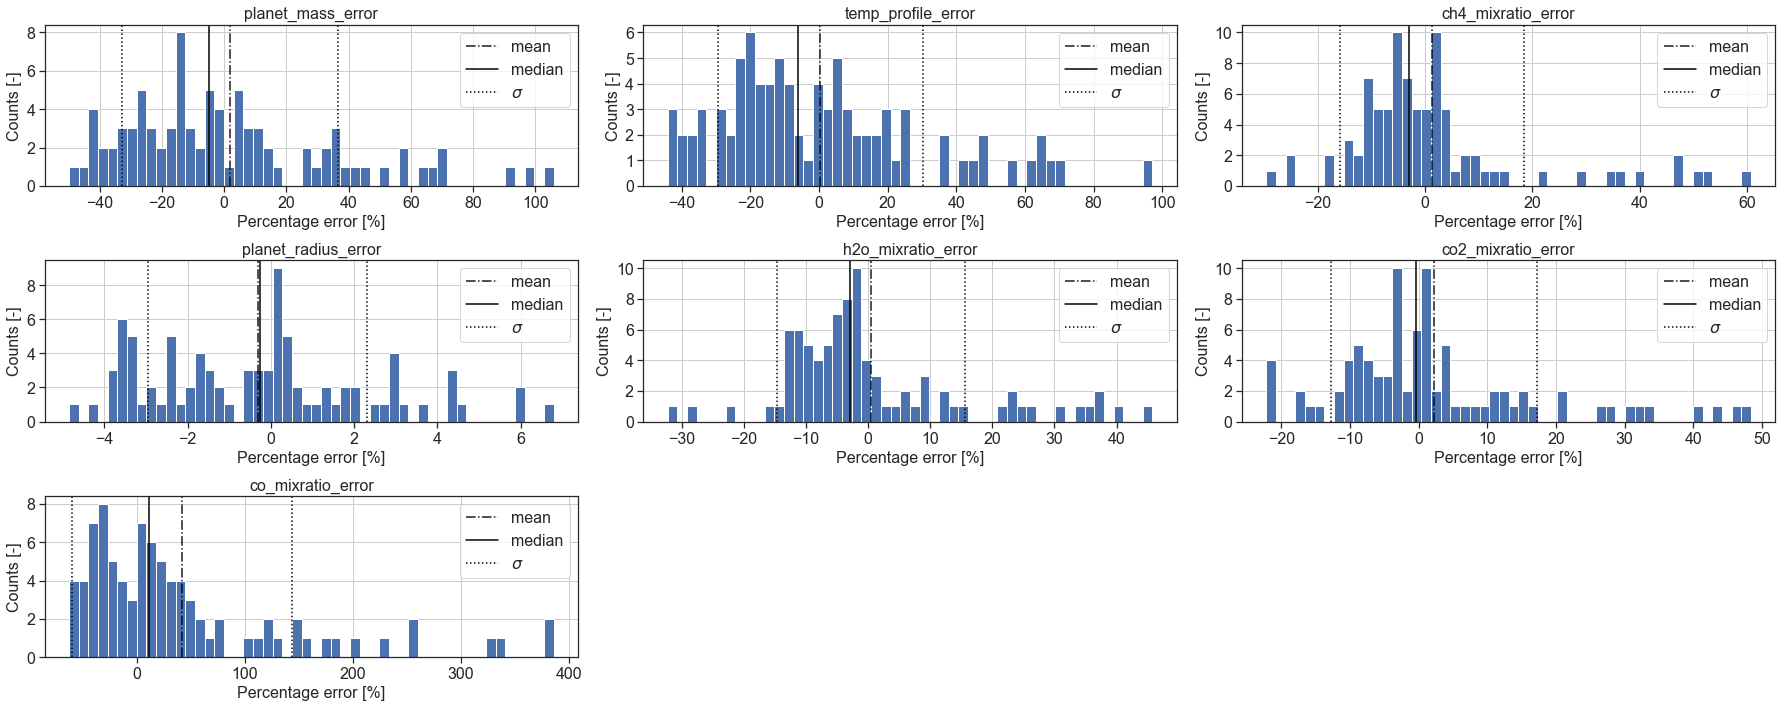

In [2584]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
#params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

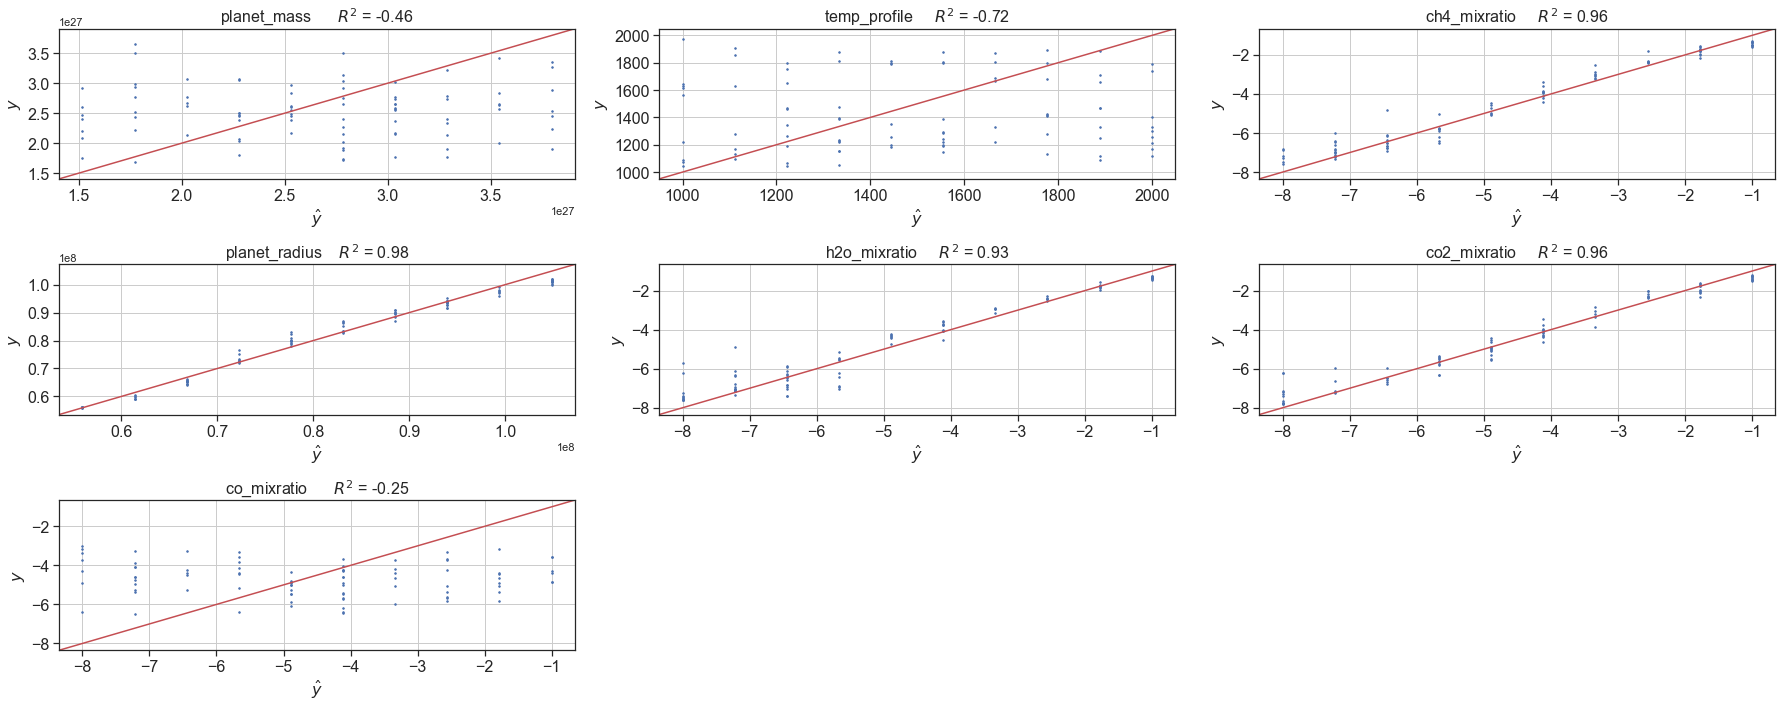

In [2585]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

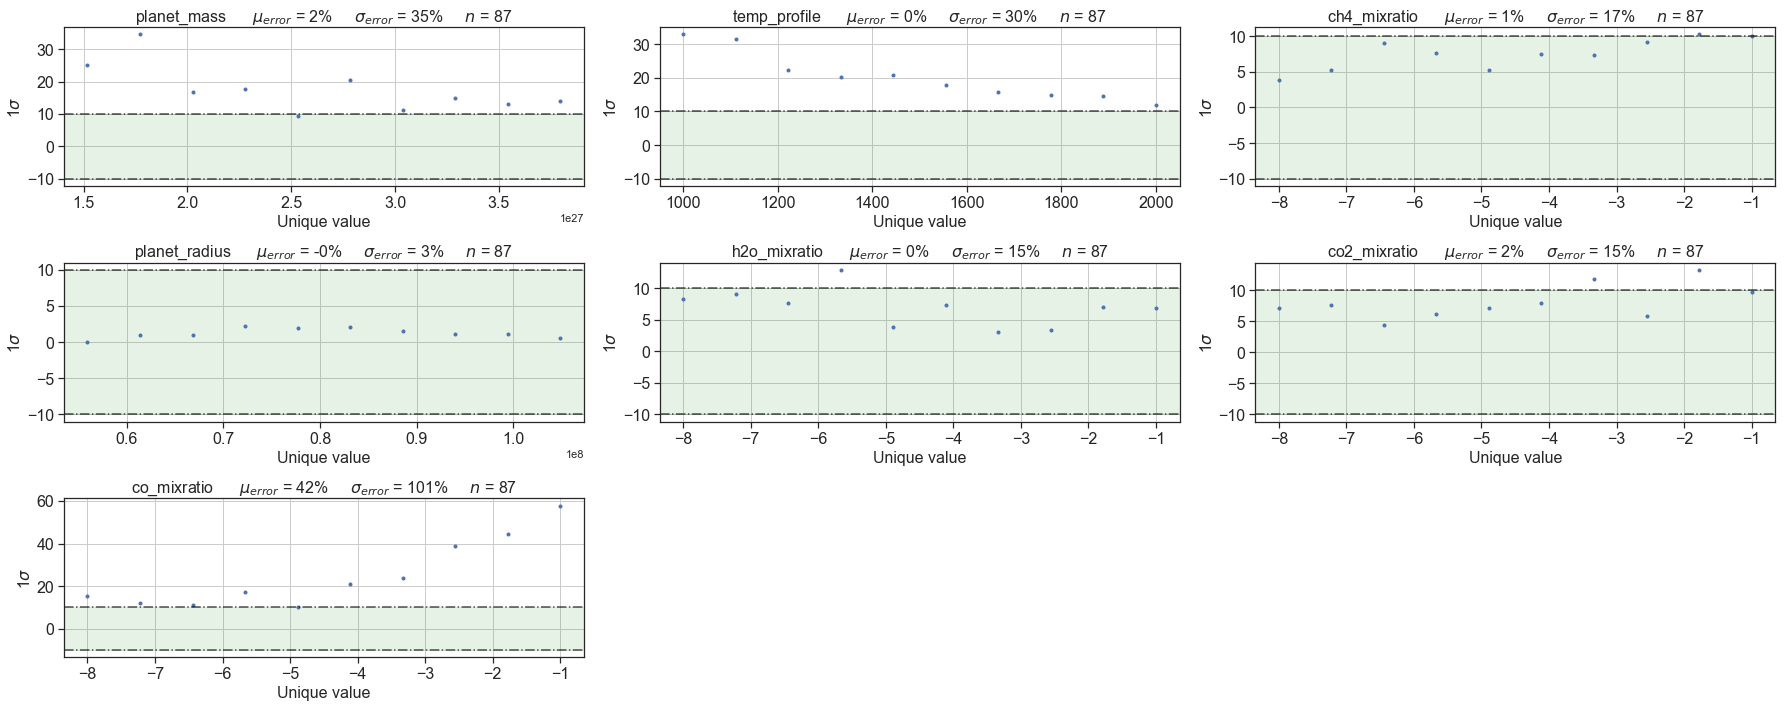

In [2586]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [2587]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999

In [2588]:
uniques

array([-2.55555546, -4.11111108, -1.77777773, -3.3333333 , -4.88888892,
       -8.        , -7.22222227, -5.6666667 , -1.        , -6.44444454])

# Losses

In [2589]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,87.000000,87.000000
mean,-0.098785,24.733780
std,0.029736,4.893788
min,-0.176072,18.449173
25%,-0.116432,21.335056
50%,-0.098247,23.741032
75%,-0.078049,26.177733
max,-0.042934,42.699699


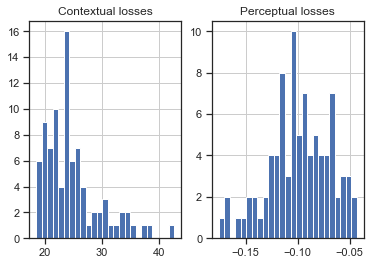

In [2590]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

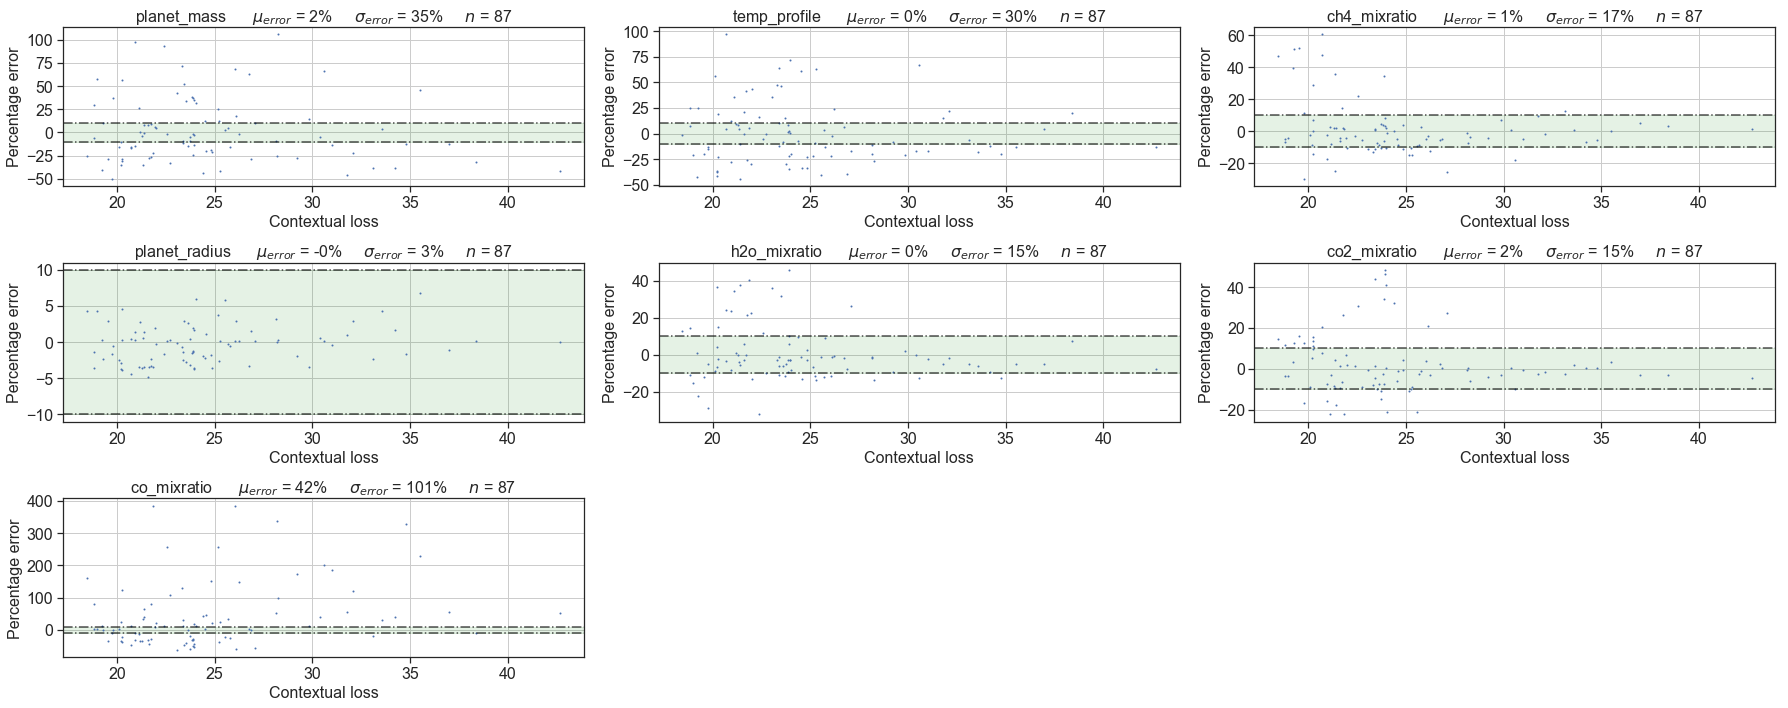

In [2591]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

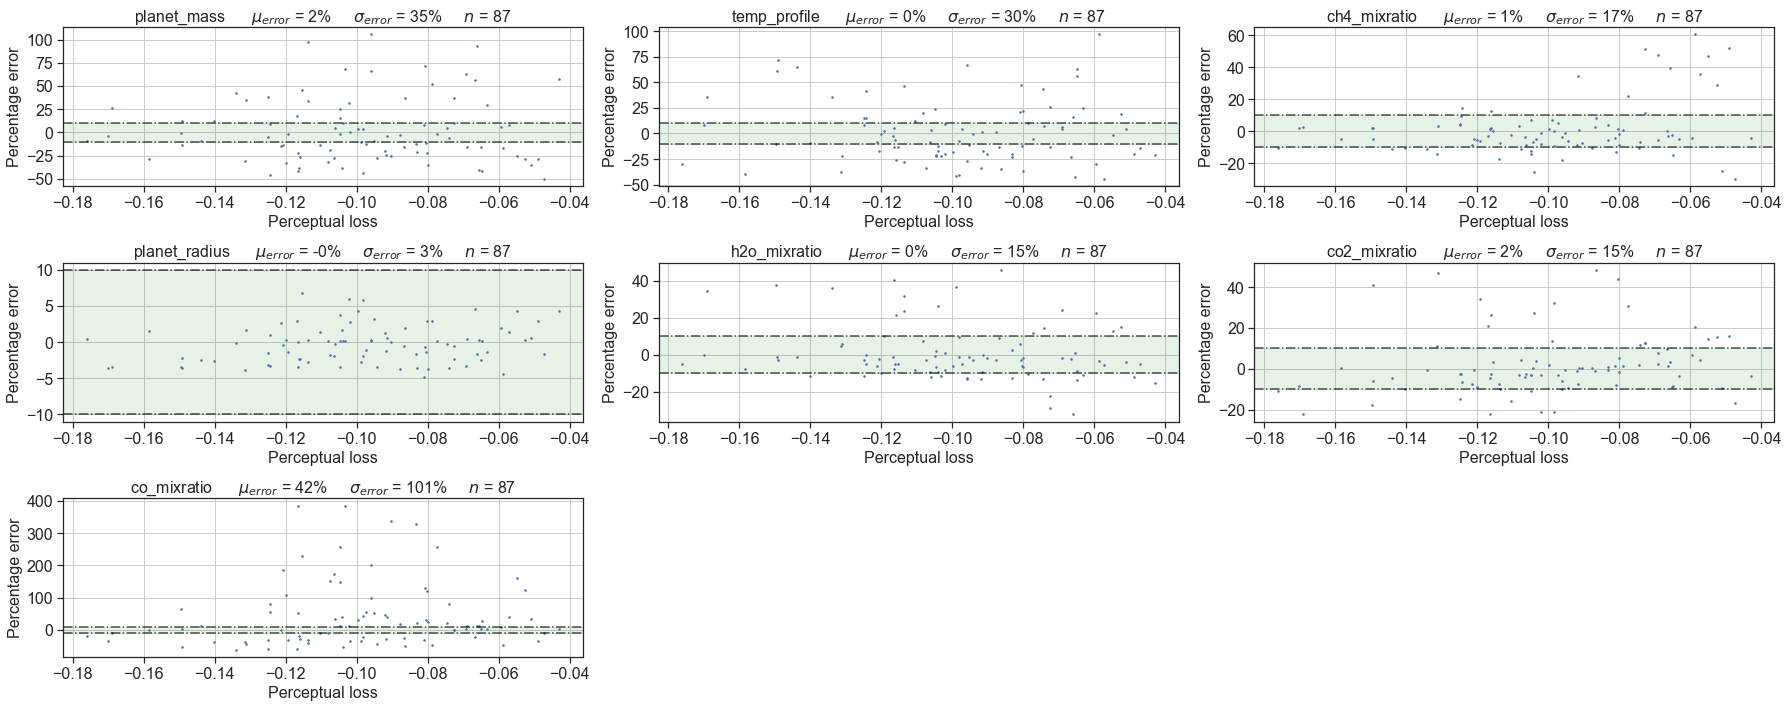

In [2592]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()